# Scaler dataframe for Auger Open Data 
## A Neutron Monitor Comparison

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import augerscalerpy.plot_config as pc
from augerscalerpy.scaler_cleaning import scaler_clean, plot_data ## ESTA SÍ ESSSSS LA FORMAAAAAAAAAAA!!!!!!!!


In [28]:
NM = pd.read_csv('nm_data/NM_izmiran.csv')

## Bases de datos disponibles

#### https://www.nmdb.eu/nest/
#### https://cidas.isee.nagoya-u.ac.jp/WDCCR/station_list.php
#### Las páginas oficiales de las estaciones: http://cr0.izmiran.ru/common/
#### El servicio de IZMIRAN http://cr0.izmiran.ru/rome/main.htm

Fuentes de datos oficiales con los datos corregidos:
#### México: http://www.cosmicrays.unam.mx/
#### Oulu: https://cosmicrays.oulu.fi/
#### Rome: Revisar este --> http://webusers.fis.uniroma3.it/svirco/pag_2.html


# DATOS DE NMDB: the Neutron Monitor Database
## Real-Time Database for high-resolution Neutron Monitor measurements

Trabajo con datos de algunas estaciones directamente.

### DATASETS DE LA NMDB:

In [30]:
skip_rows = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,22,23]

In [34]:
def nmdb_clean(filename):
    skip_rows = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23]
    df = pd.read_csv(filename, delimiter=';', skiprows=skip_rows, header=None)
    df.columns = ['date', 'counts/s']
    df['date'] = pd.to_datetime(df['date'])
    df['counts/s'] = df['counts/s'].astype('float64')
    print(len(df))
    columnas_numericas = df.columns[df.dtypes == 'float64']
    promedios_df = df[columnas_numericas].mean()

    # Normalizar cada columna dividiendo por su promedio
    df[columnas_numericas] = df[columnas_numericas] / promedios_df

    ################################## ELIMINANDO LOS EXCESOS

    # Supongamos que tienes un DataFrame llamado df y deseas eliminar los excesos en la columna "counts/s"
    # Define la columna objetivo
    column_name = "counts/s"

    # Calcula la media de la columna
    mean = df[column_name].mean()

    # Define un factor para determinar los valores que considerarás excesos
    threshold = 0.2  # 20% por fuera de la media

    # Reemplaza los valores que están por fuera del umbral por el valor medio
    df[column_name] = np.where(abs(df[column_name] - mean) > threshold * mean, mean, df[column_name])

    # Grafica el resultado
    df.plot(kind='scatter', s=2, x='date', y='counts/s', figsize=(10, 5), color='black')
    print(len(df))

    return df


62228
62228


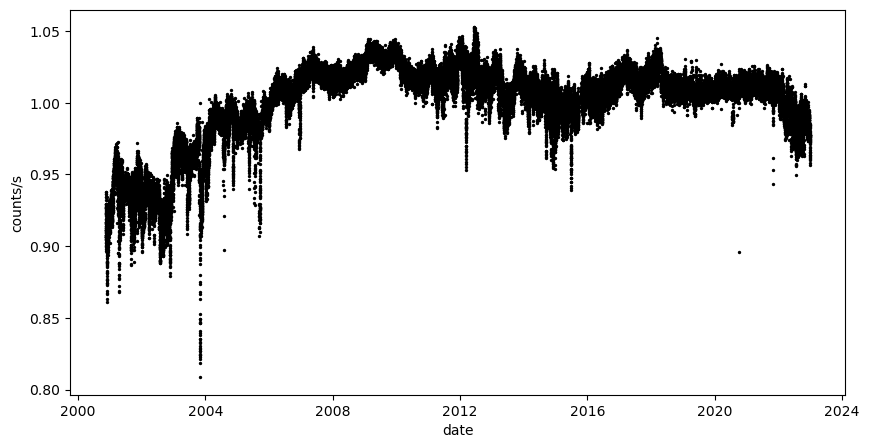

In [35]:
athenas = nmdb_clean('nm_data/long_files/athenas_NMDB.txt')

96295
96295


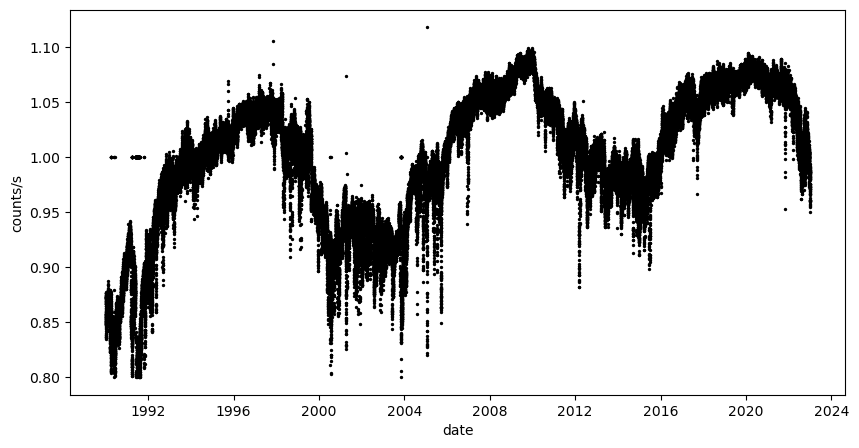

In [36]:
oulu = nmdb_clean('nm_data/long_files/Oulu_NMDB.txt')

92440
92440


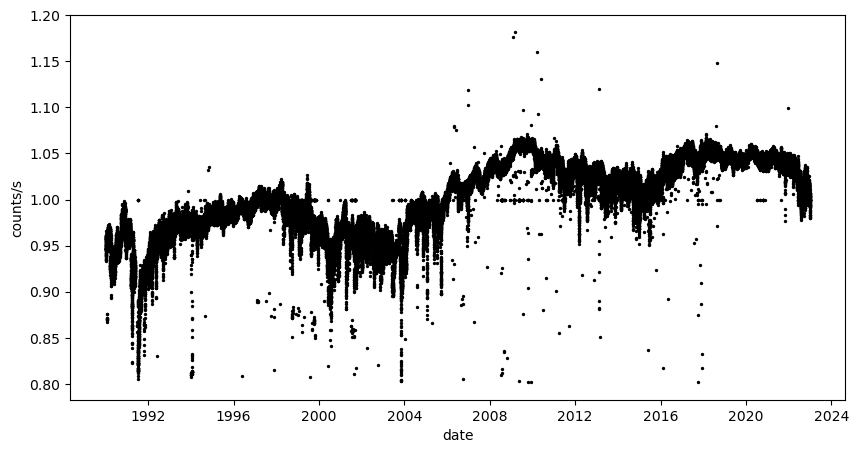

In [37]:
mexico = nmdb_clean('nm_data/long_files/mexico_NMDB.txt')

67423
67423


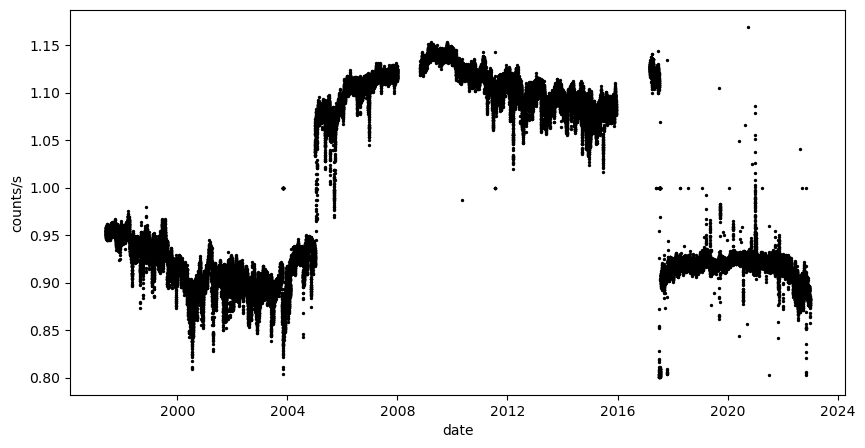

In [38]:
roma = nmdb_clean('nm_data/long_files/rome_NMDB.txt')

75223
75223


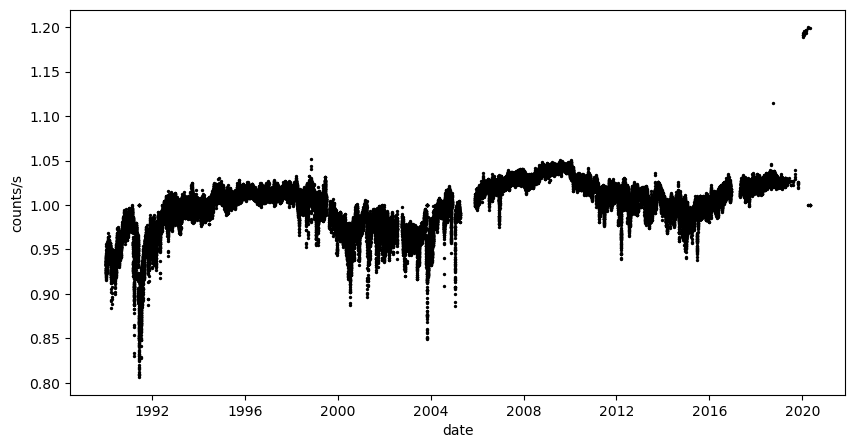

In [39]:
tsumeb = nmdb_clean('nm_data/long_files/tsumeb_NMDB.txt')

In [42]:
# Supongamos que tienes 5 DataFrames llamados df1, df2, df3, df4 y df5

# Combinar los DataFrames usando merge
combined_df = oulu.copy()  # Inicializar el DataFrame combinado con df1
#dataframes = [oulu, roma, mexico, tsumeb]
dataframes = [(athenas, "_2"), (roma, "_3"), (mexico, "_4"), (tsumeb, "_5")]

for oulu, suffix in dataframes:
    combined_df = pd.merge_asof(combined_df, oulu, on="date", suffixes=("", suffix))


#for i, athenas in enumerate(dataframes, start=2):
#    combined_df = pd.merge_asof(combined_df, athenas, on="date")

# Ahora combined_df contiene 5 columnas correspondientes a los 5 DataFrames originales
combined_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
0,1990-01-01 00:00:00,0.834653,NaN,NaN,0.934069,NaN
1,1990-01-01 03:00:00,0.835578,0.926468,NaN,0.936287,0.926468
2,1990-01-01 06:00:00,0.839871,0.926723,NaN,0.934765,0.926723
3,1990-01-01 09:00:00,0.838555,0.925214,NaN,0.933133,0.925214
4,1990-01-01 12:00:00,0.838975,0.926668,NaN,0.937709,0.926668
...,...,...,...,...,...,...
96290,2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000
96291,2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000
96292,2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000
96293,2022-12-31 18:00:00,0.991639,1.000000,0.880878,1.001411,1.000000


In [43]:
combined_df = combined_df.fillna(combined_df.mean())
combined_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
0,1990-01-01 00:00:00,0.834653,1.001531,1.006974,0.934069,1.001531
1,1990-01-01 03:00:00,0.835578,0.926468,1.006974,0.936287,0.926468
2,1990-01-01 06:00:00,0.839871,0.926723,1.006974,0.934765,0.926723
3,1990-01-01 09:00:00,0.838555,0.925214,1.006974,0.933133,0.925214
4,1990-01-01 12:00:00,0.838975,0.926668,1.006974,0.937709,0.926668
...,...,...,...,...,...,...
96290,2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000
96291,2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000
96292,2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000
96293,2022-12-31 18:00:00,0.991639,1.000000,0.880878,1.001411,1.000000


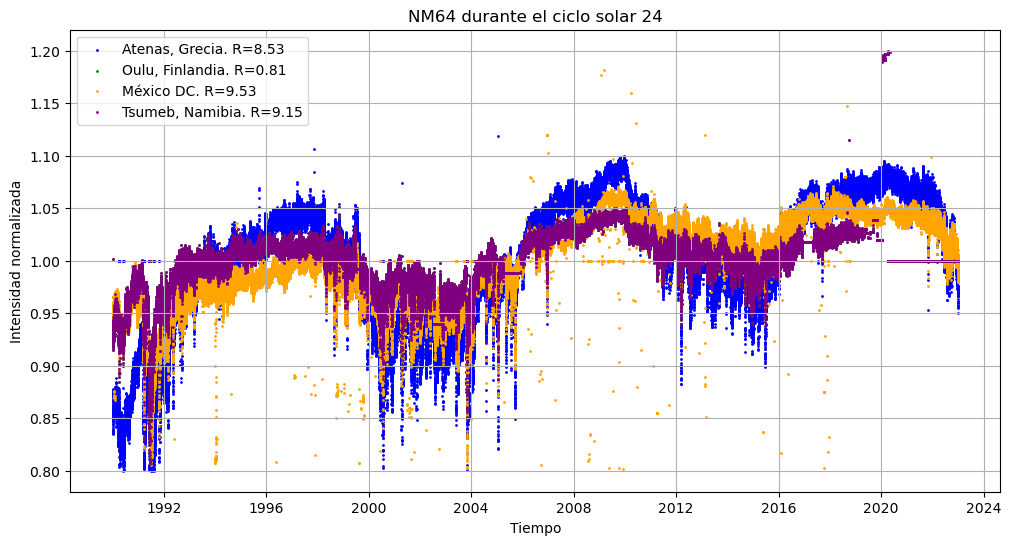

In [44]:
import matplotlib.pyplot as plt

# Suponiendo que combined_df es el DataFrame que contiene las 5 columnas
combined_df.set_index('date', inplace=True)  # Establecer la columna 'date' como el índice

athenas = combined_df['counts/s']
oulu = combined_df['counts/s_2']
#roma = combined_df['counts/s_3']
mexico = combined_df['counts/s_4']
tsumeb = combined_df['counts/s_5']

plt.figure(figsize=(12, 6))
plt.scatter(athenas.index, athenas, color='blue', label='Atenas, Grecia. R=8.53', s=1)
plt.scatter(oulu.index, oulu, color='green', label='Oulu, Finlandia. R=0.81', s=1)
#plt.scatter(roma.index, roma, color='red', label='roma')
plt.scatter(mexico.index, mexico, color='orange', label='México DC. R=9.53', s=1)
plt.scatter(tsumeb.index, tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15', s=1)

plt.xlabel('Tiempo')
plt.ylabel('Intensidad normalizada')
plt.title('NM64 durante el ciclo solar 24')
plt.legend()
plt.grid()
plt.show()



#### Incluimos los datos de Auger

In [45]:
scaler300s = scaler_clean('scaler_datasets/scaler_300s_FINAL.csv','scaler_300s')
scaler300s

Hay  (13663, 6) líneas vacías


/home/jennifer/Documentos/msc_tesis/scaler_for_solar_analysis/augerscalerpy/scaler_cleaning.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SDOK["Date"] = datetime.values


,Date,ScalerCorr,errmean,arrvar,activeSD,pressure
4086,2005-12-31 23:59:46,1604.31,0.226024,2793.15,584,857.586
4088,2006-01-01 00:09:46,1604.69,0.221103,2873.29,548,857.790
4089,2006-01-01 00:14:46,1604.73,0.220782,2696.32,545,857.893
4090,2006-01-01 00:19:46,1602.57,0.210147,2580.66,551,857.995
4091,2006-01-01 00:24:46,1602.63,0.231709,2737.53,538,858.097
...,...,...,...,...,...,...
1527671,2021-09-30 18:34:46,1665.46,0.166624,3694.81,544,856.860
1527672,2021-09-30 18:39:46,1665.10,0.179557,3716.26,549,856.860
1527673,2021-09-30 18:44:46,1666.21,0.215630,3639.40,542,856.815
1527674,2021-09-30 18:49:46,1661.49,0.378396,2635.45,287,856.770


In [46]:
#new_df.reset_index(inplace=True)
scaler300s.set_index('Date', inplace=True)


##### Resampling for 3H interval

In [47]:
# Asegúrate de que 'Date' sea el índice del DataFrame
#scaler300s.set_index('Date', inplace=True)

# Resampleando y promediando los datos cada 2 horas
new_df = scaler300s.resample('3H').mean()

# Reiniciando el índice para que 'Date' sea una columna nuevamente
new_df.reset_index(inplace=True)

# Imprimiendo el nuevo DataFrame
print(new_df)

                     Date   ScalerCorr   errmean       arrvar    activeSD  \
0     2005-12-31 21:00:00  1604.310000  0.226024  2793.150000  584.000000   
1     2006-01-01 00:00:00  1604.604857  0.204385  2651.418286  550.771429   
2     2006-01-01 03:00:00  1610.957500  0.198087  2444.086389  565.750000   
3     2006-01-01 06:00:00  1620.486389  0.196676  2720.002222  570.055556   
4     2006-01-01 09:00:00  1629.604444  0.198887  2609.530833  570.805556   
...                   ...          ...       ...          ...         ...   
46011 2021-09-30 06:00:00  1658.923889  0.170360  3141.150000  621.472222   
46012 2021-09-30 09:00:00  1663.651667  0.174043  3337.714167  626.916667   
46013 2021-09-30 12:00:00  1671.478056  0.182038  3461.950556  599.388889   
46014 2021-09-30 15:00:00  1666.070278  0.183170  3608.169444  577.583333   
46015 2021-09-30 18:00:00  1664.736364  0.283859  3611.068182  486.818182   

         pressure  
0      857.586000  
1      859.529457  
2      861.5475

In [48]:
combined_df

,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
date,,,,,
1990-01-01 00:00:00,0.834653,1.001531,1.006974,0.934069,1.001531
1990-01-01 03:00:00,0.835578,0.926468,1.006974,0.936287,0.926468
1990-01-01 06:00:00,0.839871,0.926723,1.006974,0.934765,0.926723
1990-01-01 09:00:00,0.838555,0.925214,1.006974,0.933133,0.925214
1990-01-01 12:00:00,0.838975,0.926668,1.006974,0.937709,0.926668
...,...,...,...,...,...
2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000
2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000
2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000


In [49]:
combined_df.reset_index(inplace=True)
combined_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5
0,1990-01-01 00:00:00,0.834653,1.001531,1.006974,0.934069,1.001531
1,1990-01-01 03:00:00,0.835578,0.926468,1.006974,0.936287,0.926468
2,1990-01-01 06:00:00,0.839871,0.926723,1.006974,0.934765,0.926723
3,1990-01-01 09:00:00,0.838555,0.925214,1.006974,0.933133,0.925214
4,1990-01-01 12:00:00,0.838975,0.926668,1.006974,0.937709,0.926668
...,...,...,...,...,...,...
96290,2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000
96291,2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000
96292,2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000
96293,2022-12-31 18:00:00,0.991639,1.000000,0.880878,1.001411,1.000000


In [50]:
import pandas as pd

# Supongamos que tienes los DataFrames "combined_df" y "new_df"
# Establece la columna "Date" como índice en ambos DataFrames
combined_df.set_index("date", inplace=True)
new_df.set_index("Date", inplace=True)

# Realiza la fusión en función del índice (que ahora es la columna "Date")
result_df = pd.merge_asof(combined_df, new_df, left_index=True, right_index=True, suffixes=("", "_new"))

# Restablece el índice si lo deseas
result_df.reset_index(inplace=True)

# "result_df" contiene las 6 columnas originales y "ScalerCorr_new" del DataFrame "new_df"
result_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5,ScalerCorr,errmean,arrvar,activeSD,pressure
0,1990-01-01 00:00:00,0.834653,1.001531,1.006974,0.934069,1.001531,NaN,NaN,NaN,NaN,NaN
1,1990-01-01 03:00:00,0.835578,0.926468,1.006974,0.936287,0.926468,NaN,NaN,NaN,NaN,NaN
2,1990-01-01 06:00:00,0.839871,0.926723,1.006974,0.934765,0.926723,NaN,NaN,NaN,NaN,NaN
3,1990-01-01 09:00:00,0.838555,0.925214,1.006974,0.933133,0.925214,NaN,NaN,NaN,NaN,NaN
4,1990-01-01 12:00:00,0.838975,0.926668,1.006974,0.937709,0.926668,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96290,2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
96291,2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
96292,2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
96293,2022-12-31 18:00:00,0.991639,1.000000,0.880878,1.001411,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636


In [51]:
# Reemplazar NaN en "ScalerCorr" por el promedio de la columna
mean_scaler_corr = result_df["ScalerCorr"].mean()
result_df["ScalerCorr"].fillna(mean_scaler_corr, inplace=True)

# Reemplazar NaN en "errmean" por cero
result_df["errmean"].fillna(0, inplace=True)
result_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5,ScalerCorr,errmean,arrvar,activeSD,pressure
0,1990-01-01 00:00:00,0.834653,1.001531,1.006974,0.934069,1.001531,1659.424555,0.000000,NaN,NaN,NaN
1,1990-01-01 03:00:00,0.835578,0.926468,1.006974,0.936287,0.926468,1659.424555,0.000000,NaN,NaN,NaN
2,1990-01-01 06:00:00,0.839871,0.926723,1.006974,0.934765,0.926723,1659.424555,0.000000,NaN,NaN,NaN
3,1990-01-01 09:00:00,0.838555,0.925214,1.006974,0.933133,0.925214,1659.424555,0.000000,NaN,NaN,NaN
4,1990-01-01 12:00:00,0.838975,0.926668,1.006974,0.937709,0.926668,1659.424555,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96290,2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
96291,2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
96292,2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636
96293,2022-12-31 18:00:00,0.991639,1.000000,0.880878,1.001411,1.000000,1664.736364,0.283859,3611.068182,486.818182,856.868636


##### Toca normalizar ScalerCorr para que se pueda comparar...

In [52]:
promedios_df = result_df['ScalerCorr'].mean()

    # Normalizar cada columna dividiendo por su promedio
result_df['ScalerCorr'] = result_df['ScalerCorr'] / promedios_df
#result_df.to_csv('nm_data/CRI_auger-NMs.csv', index=False)
result_df

,date,counts/s,counts/s_2,counts/s_3,counts/s_4,counts/s_5,ScalerCorr,errmean,arrvar,activeSD,pressure
0,1990-01-01 00:00:00,0.834653,1.001531,1.006974,0.934069,1.001531,1.000000,0.000000,NaN,NaN,NaN
1,1990-01-01 03:00:00,0.835578,0.926468,1.006974,0.936287,0.926468,1.000000,0.000000,NaN,NaN,NaN
2,1990-01-01 06:00:00,0.839871,0.926723,1.006974,0.934765,0.926723,1.000000,0.000000,NaN,NaN,NaN
3,1990-01-01 09:00:00,0.838555,0.925214,1.006974,0.933133,0.925214,1.000000,0.000000,NaN,NaN,NaN
4,1990-01-01 12:00:00,0.838975,0.926668,1.006974,0.937709,0.926668,1.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96290,2022-12-31 09:00:00,0.989913,1.000000,0.882938,0.993959,1.000000,1.003201,0.283859,3611.068182,486.818182,856.868636
96291,2022-12-31 12:00:00,0.988797,1.000000,0.882110,1.000053,1.000000,1.003201,0.283859,3611.068182,486.818182,856.868636
96292,2022-12-31 15:00:00,0.992040,1.000000,0.881771,1.000048,1.000000,1.003201,0.283859,3611.068182,486.818182,856.868636
96293,2022-12-31 18:00:00,0.991639,1.000000,0.880878,1.001411,1.000000,1.003201,0.283859,3611.068182,486.818182,856.868636


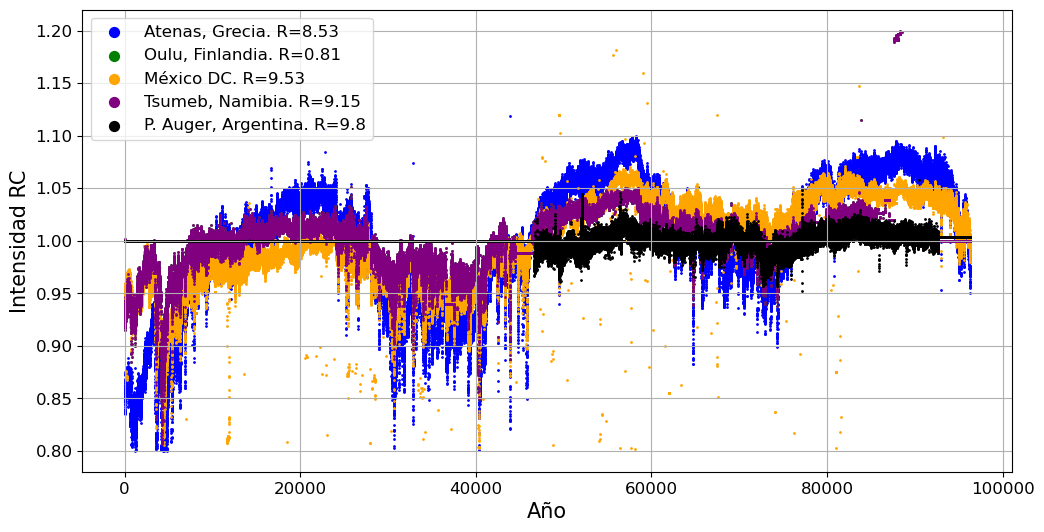

In [54]:
import matplotlib.pyplot as plt

athenas = result_df['counts/s']
oulu = result_df['counts/s_2']
# roma = combined_df['counts/s_3']
mexico = result_df['counts/s_4']
tsumeb = result_df['counts/s_5']
auger = result_df['ScalerCorr']

plt.figure(figsize=(12, 6))
plt.scatter(athenas.index, athenas, color='blue', label='Atenas, Grecia. R=8.53', marker='o', s=1)
plt.scatter(oulu.index, oulu, color='green', label='Oulu, Finlandia. R=0.81', marker='o', s=1)
# plt.scatter(roma.index, roma, color='red', label='roma')
plt.scatter(mexico.index, mexico, color='orange', label='México DC. R=9.53', marker='o', s=1)
plt.scatter(tsumeb.index, tsumeb, color='purple', label='Tsumeb, Namibia. R=9.15', marker='o', s=1)
plt.scatter(auger.index, auger, color='black', label='P. Auger, Argentina. R=9.8', marker='o', s=1)

plt.xlabel('Año', fontsize=15)
plt.ylabel('Intensidad RC', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('')

# Crear una leyenda personalizada con marcadores más grandes
legend = plt.legend(fontsize=12)
for handle in legend.legendHandles:
    handle.set_sizes([50])  # Ajustar el tamaño de los marcadores en la leyenda

plt.grid()
#plt.savefig('NM_Auger_comparison.pdf', dpi=300)
#plt.savefig('NM_Auger_comparison.png')
plt.show()